## IPR for the Russomano System

Here, we check the IPR of the Floquet states of the periodically kicked LMG Hamiltonian, where the propagator at $t=T=2\pi/\omega$ is given by

\begin{equation*}
\hat{U}(T) = \exp{\Big[-i\phi \hat{S}^x\Big]}\otimes\exp{\Big[-i\hat{H}(h)T\Big]}
\end{equation*}

and
\begin{align*}
\hat{H}(h) &= -\frac{2}{N}\sum^N_{ij}\hat{s}^z_i\hat{s}^z_j - 2h\sum^N_i \hat{s}^x_i\\
&= -\frac{2}{N}\bigg(\hat{S}^z\bigg)^2 - 2h \hat{S}^z.
\end{align*}

In [107]:
from qutip import floquet_modes, jmat


def get_hamiltonians(args):
    N = args['N']
    h = args['h']
    phi = args['phi']

    
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  -2.0/N                                      # kacNorm
    H = kn * sz **2 - 2 * h * sx 
    HK = phi * sx
    return H,HK


def floq_get(args):
    T = 2 * np.pi/args['omega']
    H, HK = get_hamiltonians(args)
    UK = (-(1j)* HK).expm() * ((-1j) * H * T).expm()
    f_states, _ = floquet_modes(H, T, args=args, U =UK)
    return f_states

print("Definitions complete!")

Definitions complete!


In [117]:
%%time
from qutip import Qobj, jmat, Options
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros

N = 10
omega = 100
nprocs = 4
h = np.sqrt(3)*N

w = omega

psteps = 400

p1 = 0.01
p2 = 50 * omega * np.pi

ps = np.linspace(p1, p2, psteps)

p = Pool(processes = nprocs)          
print("running for N = ", N, "with",nprocs,"processors")  

#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)
params = [{'h':h,'phi':phi ,'omega':omega, 'N':N, 'opts':opts} for phi in ps]
f_stateslist = p.map(floq_get,tqdm(params, position=0, leave=True))

iprmat = np.zeros((len(hs),2*N+1))

sx = jmat(N,"x")
en, st = sx.eigenstates()

print("\n Done. Now calculating IPR ...")
for xx,h in enumerate(hs):
    f_states = f_stateslist[xx]
    iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
print("Exact simulation complete!")

running for N =  10 with 4 processors


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 25101.31it/s]



 Done. Now calculating IPR ...
Exact simulation complete!
CPU times: user 695 ms, sys: 181 ms, total: 876 ms
Wall time: 7.84 s


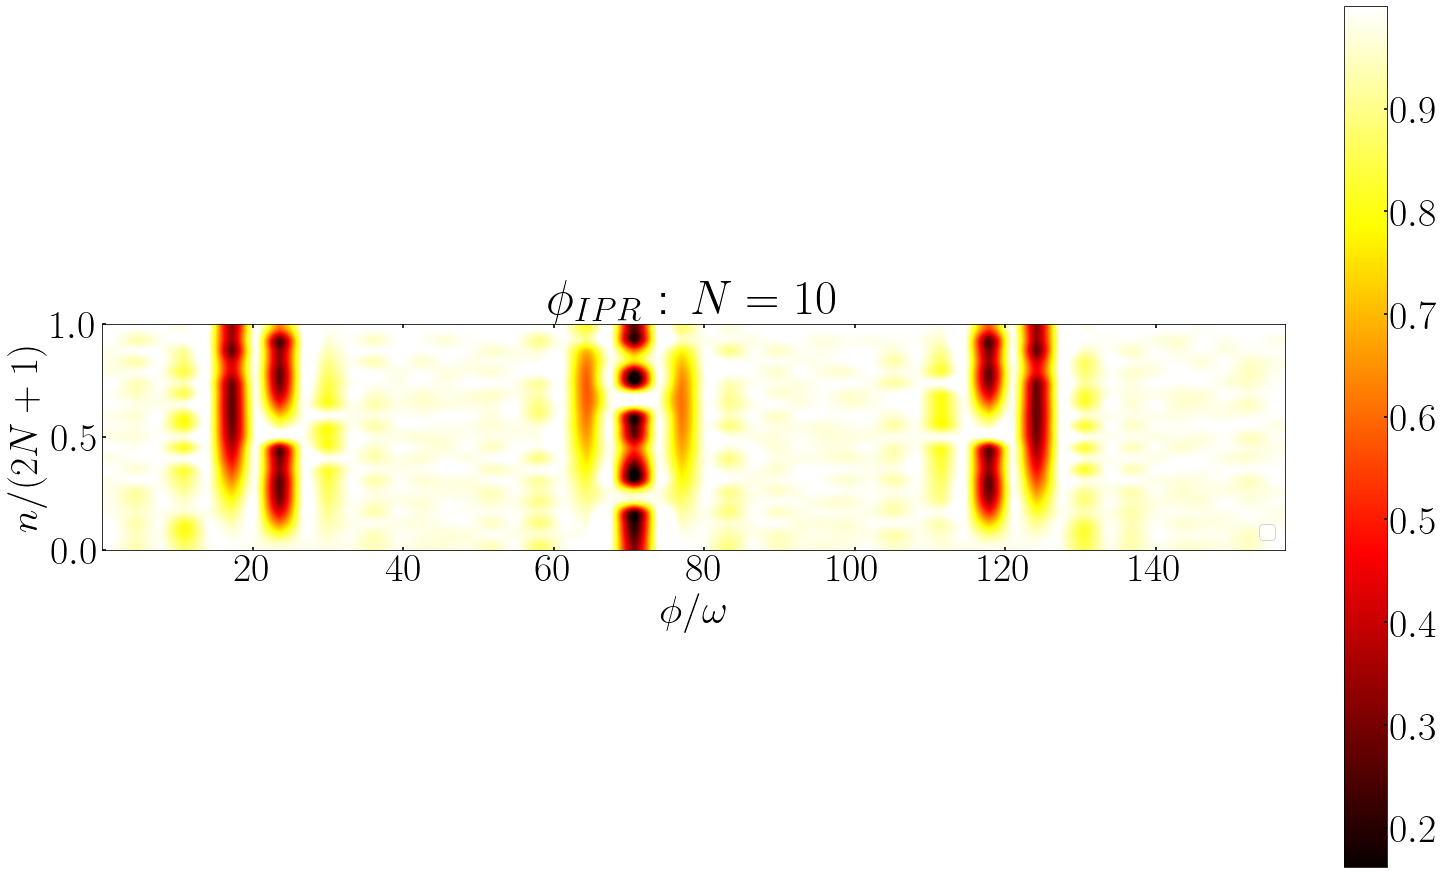

In [118]:
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.interpolate import make_interp_spline


plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})


from scipy.special import jn_zeros


fig = plt.figure(constrained_layout=True)

ipr_ax = fig.subplots(1,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {N}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 3*N
ipr_ax.set_xlabel(r'$\phi/\omega$')
ipr_ax.set_ylabel(r'$n/(2N+1)$')


im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [ps[0]/omega , ps[-1]/omega, 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.6)


plt.legend(loc="lower right", fontsize=20)
plt.show()